In [1]:
# import cell
%matplotlib inline
import glob
import cv2
import numpy as np
import scipy.misc as smp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import re
import os
import json
import math
import random

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [2]:
# read csv and make data map

def get_image_name(name, regex):
    m = re.search(regex, name)
    if m:
        return m.group(1)
    
def read_data_file(path, steer_buff=0.0):
    # http://www.pythonforbeginners.com/systems-programming/using-the-csv-module-in-python/
    ifile  = open(path, "r")
    reader = csv.reader(ifile)

    image_steering_map = {}

    rownum = 0
    for row in reader:
        # Save header row.
        if rownum == 0:
            header = row
        else:
            colnum = 0
            image_name_center = ''
            image_name_left = ''
            image_name_right = ''
            steering = 0.0
            for col in row:
                if colnum == 0:
                    image_name_center = get_image_name(col, 'IMG/(.*)')
                if colnum == 1:
                    image_name_left = get_image_name(col, 'IMG/(.*)')
                if colnum == 2:
                    image_name_right = get_image_name(col, 'IMG/(.*)')
                elif colnum == 3:
                    steering = float(col)
                colnum += 1
            image_steering_map[image_name_center] = steering
            image_steering_map[image_name_left] = steering + steer_buff
            image_steering_map[image_name_right] = steering - steer_buff

        rownum = rownum + 1
        
    return image_steering_map
        
image_steering_map = read_data_file('data/driving_log.csv', 0.16)
# print(image_steering_map)
def bgr_to_rgb(img):
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return img2

In [3]:
def get_inverted (image_map):
    inv_image_map = {}
    for key, value in image_map.items():
        if(value > -0.02 and value < 0.02):
            continue
        inv_image_map[key + "-INV"] = value * -1
    return inv_image_map

In [4]:
inv_image_steering_map = get_inverted(image_steering_map)

In [5]:
final_image_map = {**image_steering_map, **inv_image_steering_map}
len(final_image_map)

42902

(80, 320, 3)


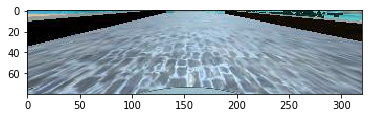

In [6]:
def crop_image(image, top=0.4, bottom=0.1):
    rows = image.shape[0]
    cols = image.shape[1]
    new_top = math.ceil(top*rows)
    new_bot = math.ceil(bottom*rows)
    return image[new_top:rows-new_bot,]

img = cv2.imread("data/IMG/center_2016_12_01_13_30_48_287.jpg")
crop_img = crop_image(img, 0.4, 0.1)
print(crop_img.shape)
plt.imshow(crop_img)

In [7]:
def read_image(path):
    images = {}
    for img in glob.glob(path):
        file_name = get_image_name(img, 'data/IMG/(.*)')
        read_image = cv2.imread(img)
        read_image = crop_image(read_image)
#         read_image = cv2.resize(read_image, (0,0), fx=0.5, fy=0.5)
#         read_image = read_image.astype(np.float32)
        images[file_name] = bgr_to_rgb(read_image)
        
    return images

In [8]:
def convert_to_numpy_array(arr):
    return np.asarray(arr).astype(np.float32)

In [9]:
def get_flipped_image(image):
    return cv2.flip(image, 1)

In [10]:
def get_image(image_map, name):
    image_arr = name.split("-")
    if len(image_arr) == 1:
        return image_map[name]
    else:
        if image_arr[1] == "INV":
            return get_flipped_image(image_map[image_arr[0]])

In [11]:
images = read_image('data/IMG/*')
# images, steering = read_image('sample/*')
print(len(images))




24108


In [ ]:
# comma.ai
def get_model(time_len=1):
  ch, row, col = 3, 160, 320  # camera format

  model = Sequential()
  model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
  model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))

  model.compile(optimizer="adam", loss="mse")

  return model


In [12]:
def resize(image):
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, (66, 200))

def normalize(image):
    return image / 255.0 - 0.5

In [25]:
def get_model_nvidia():
#     ch, row, col = 3, 80, 320
    ch, row, col = 3, 66, 200
    model = Sequential()
#     model.add(Lambda(lambda x: x/127.5 - 1.,
#             input_shape=(row, col, ch),
#             output_shape=(row, col, ch)))
    model.add(Lambda(resize,
            input_shape=(80, 320, ch),
            output_shape=(row, col, ch)))
    model.add(Lambda(normalize))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid', init="he_normal"))
    model.add(ELU())
    model.add(Convolution2D(128, 3, 3, subsample=(1, 1), border_mode='valid', init="he_normal"))
    model.add(ELU())
    
    model.add(Flatten())
    
    model.add(Dense(100, init="he_normal"))
    model.add(ELU())
    model.add(Dropout(.5))
    
    model.add(Dense(50, init="he_normal"))
    model.add(ELU())
    model.add(Dropout(.5))
    
    model.add(Dense(10, init="he_normal"))
    model.add(ELU())
    model.add(Dropout(.5))
    
    model.add(Dense(1, init="he_normal"))
    
    # https://arxiv.org/pdf/1412.6980v8.pdf
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss="mse")
    
    model.summary()
    
    return model

In [26]:

image_list = list(final_image_map.items())
random.shuffle(image_list)


In [27]:
data_len = len(image_list)
size_train = math.ceil(data_len * 0.66)
size_test = data_len - size_train
print(size_train)
print(size_test)
train_data = image_list[0:size_train]
valid_data = image_list[size_train: size_train+size_test]
print(len(train_data))
print(len(valid_data))

28316
14586
28316
14586


In [28]:
def data_iterator(data, size):
    """ A simple data iterator """
    while True:
        # shuffle labels and features
        random.shuffle(data)
        
        batch_size = size
        for batch_idx in range(0, len(data), batch_size):
            data_batch = data[batch_idx:batch_idx+batch_size]
#             tuple_list = [(a, some_process(b)) for (a, b) in tuple_list]
            images_batch = np.array([get_image(images, a) for (a, b) in data_batch])
            labels_batch = np.array([b for (a, b) in data_batch])
        
            yield (images_batch, labels_batch)

In [29]:
BATCH_SIZE = 128
EPOCH = 15

model = get_model_nvidia()

# Create checkpoint at which model weights are to be saved
checkpoint = ModelCheckpoint("outputs/steering_model/model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

model.fit_generator(
data_iterator(train_data, BATCH_SIZE),
samples_per_epoch=len(train_data),
nb_epoch=EPOCH,
callbacks=[checkpoint],
validation_data=data_iterator(valid_data, BATCH_SIZE),
nb_val_samples=500
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 66, 200, 3)    0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
lambda_6 (Lambda)                (None, 66, 200, 3)    0           lambda_5[0][0]                   
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 31, 98, 24)    1824        lambda_6[0][0]                   
____________________________________________________________________________________________________
elu_17 (ELU)                     (None, 31, 98, 24)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________

In [ ]:
BATCH_SIZE = 128
EPOCH = 5

model = get_model_nvidia()
history = model.fit(np_images, np_streering,
                    batch_size=BATCH_SIZE, nb_epoch=EPOCH,
                    verbose=1, validation_data=(np_images, np_streering))
arr = model.predict(np_images)
print(np_streering)
print(arr)
# score = model.evaluate(np_images, np_streering, verbose=0)
# print(score)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

In [30]:
print("Saving model weights and configuration file.")

if not os.path.exists("./outputs/steering_model"):
  os.makedirs("./outputs/steering_model")

# model.save_weights("./outputs/steering_model/model.h5", True)
with open('./outputs/steering_model/model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Saving model weights and configuration file.
